# Running noisy simulations

The aim of this notebook is to show how to do Monte Carlo simulations of noisy systems in emu-mps. The focus is on demonstrating the API, for information about the algorithm used, runtime and memory characteristics and potential pitfalls, please refer to the documentation.

We will run a sequence without driving or interactions, starting from the `11` state, with dephasing and spontaneous emission noise, and show that when enough Monte Carlo runs are performed, the probability to find the first qubit in the `1` state decays with the spontaneous emission rate, as expected. It is impossible to run the simulation for a single qubit, since emu-mps does not support this edge case.

First we import the required packages

In [1]:
import pulser
import emu_mps
import emu_base
import numpy as np
import logging #used to turn of logging in emu_mps

Next we define the registers. Since we will turn off interactions, the qubit positions are arbitrarily chosen based on my number of fingers.

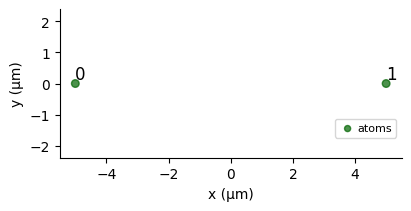

In [2]:
reg = pulser.Register.from_coordinates([[0,0],[10,0]])
reg.draw(blockade_radius=1e-10, draw_graph=True, draw_half_radius=True) #draw blockade radius as 0, since we will mask interactions in the MPSConfig

Next we define the `Sequence`. It consists of one constant pulse on the Rydberg channel with no amplitude and detuning. The duration of the pulse is taken as `t=1000` since it makes the graphs a nice length. It also has to be a multiple of whatever `dt` we choose below, which we keep at the default `dt=10`.

In [3]:
seq = pulser.Sequence(reg, pulser.devices.MockDevice)
t = 1000
pulse = pulser.Pulse.ConstantAmplitude(
        0., pulser.waveforms.ConstantWaveform(t, 0.), 0.0
    )
seq.declare_channel("ising_global", "rydberg_global")
seq.add(pulse, "ising_global")

We define the noise model to contain both a relaxation and a dephasing. For the system in question, dephasing has no actual influence on the dynamics since the system is always in an eigenstate of the dephasing jump operator. It's interesting to see that the correct relaxation rate still appears in the graphs though, which is why we are adding it. We're putting the rates to `1.` so that all the scaling of the graphs is in `t`

In [4]:
noise = pulser.NoiseModel(relaxation_rate=1, dephasing_rate=1.)

We'll measure the qubit density after each time step. Since we keep the default value of `dt=10` this means the measurements are at each multiple of `10ns`, as defined in `times` below.

In [5]:
times = np.arange(10., 1000., 10)
times /= seq.get_duration()
basis = ("r", "g")
magnetization = emu_mps.Occupation(evaluation_times=times)

As described at the start of the notebook, we start from the `11` state.

In [6]:
#define initial state
initial_state = emu_mps.MPS.from_state_amplitudes(amplitudes={"rr":1.},eigenstates=basis)

Now we create the `MPSConfig` and `MPSBackend` for the above.

In [7]:
#define config and backend
config = emu_mps.MPSConfig(
    noise_model=noise,
    num_gpus_to_use=0, #small systems are faster on cpu
    interaction_cutoff=1e10, #this will put all interactions to 0, regardless of spacing
    initial_state=initial_state,
    observables=[magnetization],
    log_level = logging.WARN #don't print stuff for the many runs
)
backend = emu_mps.MPSBackend(seq, config=config)

The way to handle results for many runs, is to store all the `Results` objects separately, and compute aggregated statistics from them afterwards.

In [8]:
results = []
nruns = 500 #0.125 seconds per run on my machine
for _ in range(nruns):
    results.append(backend.run())

Will save simulation state to file "emu_mps_save_21fd4f14-08bf-11f0-a80d-b6cf08f1a91e.dat"
            every 600 seconds.
To resume: `MPSBackend().resume("/Users/kemal/Programs/Pasqal/emuteam/emulators/docs/emu_mps/notebooks/emu_mps_save_21fd4f14-08bf-11f0-a80d-b6cf08f1a91e.dat")`
Will save simulation state to file "emu_mps_save_22077d40-08bf-11f0-a80d-b6cf08f1a91e.dat"
            every 600 seconds.
To resume: `MPSBackend().resume("/Users/kemal/Programs/Pasqal/emuteam/emulators/docs/emu_mps/notebooks/emu_mps_save_22077d40-08bf-11f0-a80d-b6cf08f1a91e.dat")`
Will save simulation state to file "emu_mps_save_2210e36c-08bf-11f0-a80d-b6cf08f1a91e.dat"
            every 600 seconds.
To resume: `MPSBackend().resume("/Users/kemal/Programs/Pasqal/emuteam/emulators/docs/emu_mps/notebooks/emu_mps_save_2210e36c-08bf-11f0-a80d-b6cf08f1a91e.dat")`
Will save simulation state to file "emu_mps_save_221a4132-08bf-11f0-a80d-b6cf08f1a91e.dat"
            every 600 seconds.
To resume: `MPSBackend().resume(

Let's compute the average magnetization of qubit 0 over all the simulation results for each time.
This can be done automatically by the `Results` class and its `aggregate` static factory method.
For a given callback, the `Callback.default_aggregation_type` attribute indicates how `aggregate` processes the values from different runs. This is only a go-to setting that isn't always available, and can be overriden by the user for specific cases.

In [ ]:
# ALL the comment below are waiting for Aggregation mechanism implementation
# magnetization.default_aggregation_type

AttributeError: 'Occupation' object has no attribute 'default_aggregation_type'

Here we get `AggregationType.MEAN` which indicates that qubit densities are averaged by default. To actually perform this aggregation over all results:

In [ ]:
#aggregated_results = emu_base.Results.aggregate(results)
#aggregated_results["qubit_density", 100][0] # average magnetization of qubit 0 at time 100ns

0.894

If we were instead to be interested in the _median_ qubit density over the `nruns`, we would have to define our own aggregation method. It would look like below. Note that magnetization values are given as list of lists, where each individual list corresponds to the magnetization values for qubits of a single run, and aggregation needs to happen over all those runs for each qubit separately.

In [ ]:
#import statistics
#
#def median_qubit_density(qubit_density_values: list[list[float]]):
#    return [statistics.median(qubit_density[qubit_index] for qubit_density in qubit_density_values) for qubit_index in range(2)]
#
## API for kwargs of `Results.aggregate` is `callback_name=callable_aggregator`
#aggregated_median_qubit_density = emu_base.Results.aggregate(results, qubit_density=median_qubit_density)
#aggregated_median_qubit_density["qubit_density", 100][0] # median magnetization of qubit 0 at time 100ns

1.0

The median of the magnetization at time 100ns is 1. This can be a bit surprising, but is in fact perfectly natural given how the Monte Carlo simulation works: in a single run, qubit density is not continuous but randomly jumps from 1 to 0. We can check that e.g. by turning lists of magnetization values into Python sets with only 2 elements 0 and 1:

In [ ]:
#def set_density(qubit_density_values: list[list[float]]):
#    return [set(qubit_density[qubit_index] for qubit_density in qubit_density_values) for qubit_index in range(2)]
#
#aggregated_set_qubit_density = emu_base.Results.aggregate(results, qubit_density=set_density)
#aggregated_set_qubit_density["qubit_density", 100][0]
## The extra 0.999 value comes from floating-point maths, Monte-Carlo logic and state renormalization.

{0.0, 0.9999999999999998, 1.0}


To show the convergence of that quantity as the number of runs grows, we can aggregate only the first `n <= nruns` results. Here's a utility function doing that:

In [ ]:
#def densities(results, n):
#    return [density[0] for density in emu_base.Results.aggregate(results[:n])["qubit_density"].values()]

Define the true mean of the magnetization towards which the sample statistics should converge as `nruns -> inf`

In [ ]:
#expected = [np.exp(-1*t/1000) for t in times]

Plot the magnetization. Here we see good agreement with the limit at `n=200` already, but if you're unlucky, even for `n=500` results can differ. 

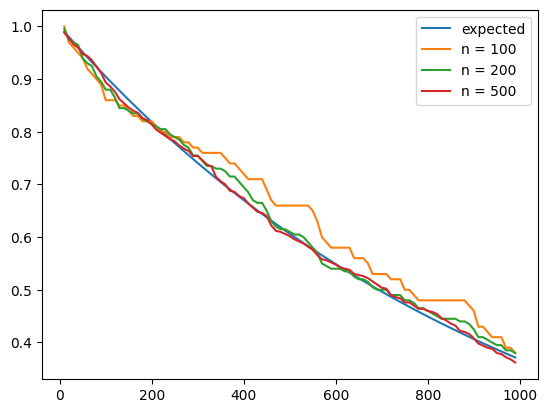

In [ ]:
#import matplotlib.pyplot as pl
#pl.plot(times, expected, label="expected")
#for n in [100, 200, 500]:
#    pl.plot(times, densities(results, n), label=f"n = {n}")
#pl.legend(loc="upper right")